In [9]:
'''

    This file runs the Genetic Algorithm


'''

#import packages
import random
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

class Genetic_Algoritm():
    def __init__(self, model, param_grid, pop_size=10, nb_gen=10, tau=0.5):
        self.model = Pipeline([('scaler', StandardScaler()), ('model', model)])
        self.pop_size = pop_size
        self.nb_gen = nb_gen
        self.param_grid = param_grid
        self.tau = tau
        self.it_nb = 0
        self.T = 0.1

    def get_init_models(self) -> list:
        '''
        Initializing population

        consider: potential input for seeding
        '''

        models = []
        for i in range(self.pop_size):
            # Getting random parameters
            rand_params = {}
            for key, value in self.param_grid.items():
                # Case float
                if type(value[0]) == float:
                    rand_params[key] = random.uniform(value[0], value[1])
                # Case int
                elif type(value[0]) == int:
                    rand_params[key] = round(
                        random.uniform(value[0], value[1]))
                # Case boolean or categorical
                else:
                    rand_params[key] = random.choice(value)

            # Creating new model
            temp_model = copy.deepcopy(self.model)
            temp_model.set_params(**rand_params)
            models.append(temp_model)

        return models

    def fit(self, Xtrain, ytrain, plot=False):
        '''
        Fitting hyperparameters 
        '''
        avg_scores_hist = []
        T_hist = [self.T]
        models = self.get_init_models()

        for i in tqdm(range(self.nb_gen)):
            self.it_nb = i
            scores = self.score_models(models, Xtrain, ytrain, k=3)
            parents, parents_scores = self.select_parents(
                models, scores)
            avg_scores_hist.append(np.mean(parents_scores))
            models = self.mate(parents)
            self.T = self.T * self.tau
            T_hist.append(self.T)

        scores = self.score_models(models, Xtrain, ytrain, k=3)
        best_score = max(scores)
        best_model = models[scores.index(best_score)]['model']
        avg_scores_hist.append(best_score)

        if plot:
            fig, axs = plt.subplots(2, 1, figsize=(8, 6))
            sns.lineplot(data=avg_scores_hist, ax=axs[0])
            axs[0].set_title("Best parent score evolution")
            sns.lineplot(data=T_hist, ax=axs[1], palette='r')
            axs[1].set_title("Temperature")
            plt.show()

        return best_model, best_model.get_params(), best_score, avg_scores_hist

    def score_models(self, models, Xtrain, ytrain, k) -> list:
        '''
        Scorring models with K-folds
        '''
        scores = []
        for model in models:
            scores.append(np.mean(cross_val_score(
                model, X=Xtrain, y=ytrain, cv=k)))

        return scores

    def select_parents(self, models, scores):
        '''
        Selecting parents
        '''

        first_best, first_best_model = self.sim_annealing(scores, models)
        scores.remove(first_best)
        second_best, second_best_model = self.sim_annealing(scores, models)

        return [first_best_model, second_best_model], [first_best, second_best]

    def sim_annealing(self, scores, models):
        if random.random() <= np.exp(-1/(self.tau/(self.it_nb + 1))):
            score = random.choice(scores)
        else:
            score = max(scores)

        model = models[scores.index(score)]
        return score, model

    def mate(self, parents) -> list:
        '''
        Mating parents
        '''
        children_models = []
        # Creating children
        for i in range(self.pop_size):
            # Getting random parameters
            rand_params = self.mix_parent_genes(parents)

            # Creating new model
            temp_model = copy.deepcopy(self.model)
            temp_model.set_params(**rand_params)
            children_models.append(temp_model)

        return children_models

    def mix_parent_genes(self, parents):
        '''
        Mix parent genes to generate new child
        '''
        parent1, parent2 = parents
        parent1_params = parent1['model'].get_params()
        parent2_params = parent2['model'].get_params()

        params = {}
        for key in self.param_grid.keys():
            splitkey = key.split("__")[1]
            params[key] = self.get_random_param(
                parent1_params[splitkey], parent2_params[splitkey], key)

        return params

    def get_random_param(self, value1, value2, key):
        '''
        Choosing random values
        '''
        if random.random() <= np.exp(-1/(self.tau/(self.it_nb + 1))):
            value = self.param_grid[key]
            # Case float
            if type(value[0]) == float:
                return random.uniform(value[0], value[1])
            # Case int
            elif type(value[0]) == int:
                return round(random.uniform(value[0], value[1]))
            # Case boolean or categorical
            else:
                return random.choice(value)
        else:
            # Case float
            if type(value1) == float:
                return random.uniform(value1, value2)
            # Case int
            elif type(value1) == int:
                return round(random.uniform(value1, value2))
            # Case boolean or categorical
            else:
                return random.choice([value1, value2])

In [10]:
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
    from sklearn.model_selection import train_test_split

    rng_seed = 2434

In [11]:
df = pd.read_csv('pulsar_data.csv')
feature_names = df.columns.values[:-1]  # removing the traget (last one)
numnulls_in_feature = dict().fromkeys(feature_names, 0)
for feature in feature_names:
    numnulls_in_feature[feature] = df[feature].isna().sum()
df = df.dropna(axis=1)
feature_names = df.columns.values[:-1]

Xtrain, Xtest, ytrain, ytest = train_test_split(df.iloc[:, :-1],
                                                df['target_class'],
                                                test_size=0.1,
                                                random_state=rng_seed)

In [12]:
model_logreg = LogisticRegression(solver='liblinear', random_state=rng_seed)
model_scm = SVC(random_state=rng_seed)
model_rf = RandomForestClassifier(random_state=rng_seed)
model_ab = AdaBoostClassifier(random_state=rng_seed)
model_gbc = GradientBoostingClassifier(random_state=rng_seed)

param_grid_logreg = {
    'model__penalty': ['l1', 'l2'],
    'model__C': np.logspace(-20, 10, 2).tolist(),
    'model__fit_intercept': [True, False],
    'model__intercept_scaling': np.logspace(0, 1, 2).tolist()}

param_grid_svm = {
    'model__kernel': ['poly', 'rbf'],
    'model__C': np.logspace(-2, 2, 2).tolist()}

param_grid_rf = {
    'model__max_features': ['sqrt', 'log2'],
    'model__n_estimators': np.linspace(2, 100, 2, dtype=int).tolist()}

param_grid_ab = {
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': np.linspace(10, 100, 2, dtype=int).tolist()}

param_grid_gbc = {
    'model__learning_rate': [0.1, 1.0],
    'model__n_estimators': [50, 100]}

In [13]:
gen1 = Genetic_Algoritm(model_logreg, param_grid_logreg, pop_size=10, nb_gen=10).fit(Xtrain, ytrain)

100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


In [14]:
gen2 = Genetic_Algoritm(model_scm, param_grid_svm, pop_size=10, nb_gen=10).fit(Xtrain, ytrain)

100%|██████████| 10/10 [02:55<00:00, 17.54s/it]


In [15]:
gen3 = Genetic_Algoritm(model_rf, param_grid_rf, pop_size=10, nb_gen=10).fit(Xtrain, ytrain)

100%|██████████| 10/10 [04:59<00:00, 29.94s/it]


In [16]:
gen4 = Genetic_Algoritm(model_ab, param_grid_ab, pop_size=10, nb_gen=10).fit(Xtrain, ytrain)

100%|██████████| 10/10 [03:33<00:00, 21.39s/it]


In [17]:
gen5 = Genetic_Algoritm(model_gbc, param_grid_gbc, pop_size=10, nb_gen=10).fit(Xtrain, ytrain)

100%|██████████| 10/10 [04:32<00:00, 27.28s/it]


In [18]:
gens = [gen1[3], gen2[3], gen3[3], gen4[3], gen5[3]]
gens_title = ['Logreg', 'SVC', 'RandomForest', 'AdaBoost', 'GradientBoost']

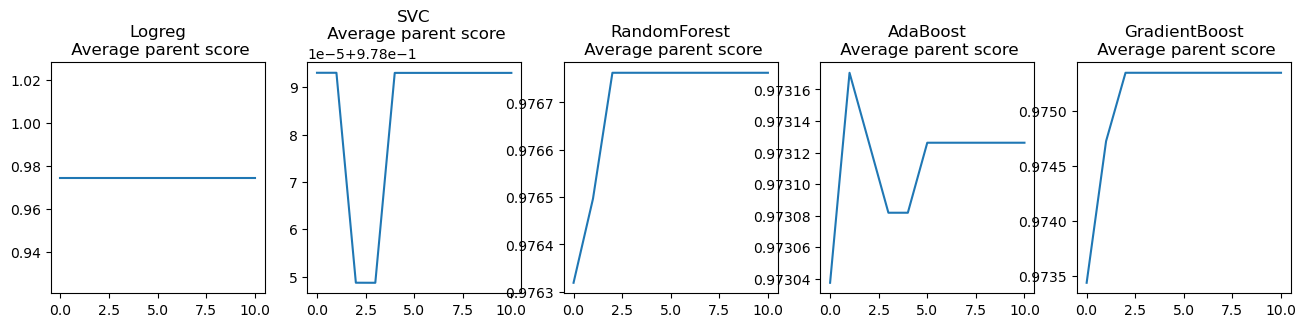

In [23]:
fig, axs = plt.subplots(1, 5, figsize=(16, 3))
i = 0
for gen in gens:
    sns.lineplot(data=gen, ax=axs[i])
    axs[i].set_title(f"{gens_title[i]}\n Average parent score")
    i+=1
plt.show()

100%|██████████| 25/25 [09:36<00:00, 23.07s/it]
/tmp/ipykernel_1293200/645605823.py:88: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=T_hist, ax=axs[1], palette='r')


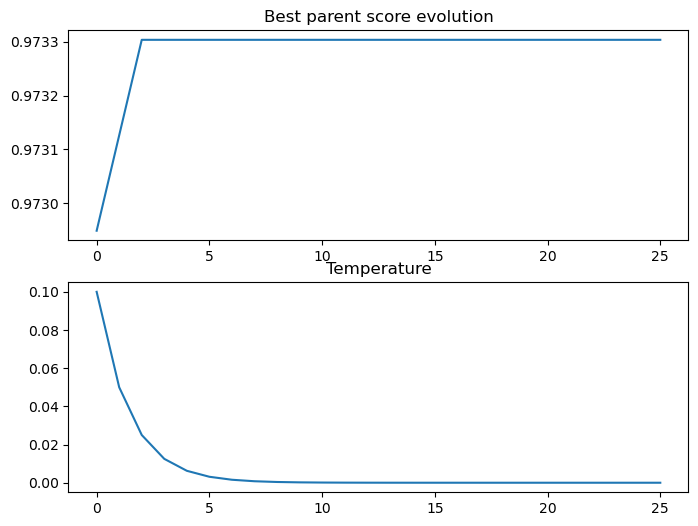

In [26]:
# best_model, best_params, best_score, plot_data = Genetic_Algoritm(model_logreg, param_grid_logreg, pop_size=10, nb_gen=50, tau=0.5).fit(
#     Xtrain, ytrain, plot=True)

best_model, best_params, best_score, plot_data = Genetic_Algoritm(model_ab, param_grid_ab, pop_size=10, nb_gen=25).fit(
    Xtrain, ytrain, plot=True)